# Libraries

In [83]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sklearn as sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# parameters
input_channels = 5 # open, high, low, close, volume
activation_function = nn.LeakyReLU()
learning_rate = 0.001
epochs = 1000
loss_function = nn.MSELoss()
window_size = 15 # 15 day window
scaler = StandardScaler()

# loading in the dataset

In [99]:
df = pd.read_csv("data.csv")
print(df)
df = df[df["Company"] == "CSCO"] # select stock option

open_data = list()
close_data = list()
high_data = list()
low_data = list()
volume_data = list()
date_data = list()

# fixing dataset format

start_index = df.index[0]

for i in range(len(df)):
  i += start_index
  open_data.append(float(df["Open"][i][1:]))
  close_data.append(float(df["Close/Last"][i][1:]))
  high_data.append(float(df["High"][i][1:]))
  low_data.append(float(df.Low[i][1:]))
  volume_data.append(float(df.Volume[i]))
  date_data.append(df.Date[i])

open_data.reverse()
high_data.reverse()
low_data.reverse()
close_data.reverse()
volume_data.reverse()
date_data.reverse()



      Company        Date Close/Last      Volume       Open       High  \
0        AAPL  07/17/2023    $193.99    50520160    $191.90    $194.32   
1        AAPL  07/14/2023    $190.69    41616240    $190.23  $191.1799   
2        AAPL  07/13/2023    $190.54    41342340    $190.50    $191.19   
3        AAPL  07-12-2023    $189.77    60750250    $189.68    $191.70   
4        AAPL  07-11-2023    $188.08    46638120    $189.16    $189.30   
5        AAPL  07-10-2023    $188.61    59922160    $189.26    $189.99   
6        AAPL  07-07-2023    $190.68    46815000    $191.41    $192.67   
7        AAPL  07-06-2023    $191.81    45156010    $189.84    $192.02   
8        AAPL  07-05-2023    $191.33    46920260   $191.565    $192.98   
9        AAPL  07-03-2023    $192.46    31346600    $193.78    $193.88   
10       AAPL  06/30/2023    $193.97    85213220    $191.63    $194.48   
11       AAPL  06/29/2023    $189.59    46347310    $189.08    $190.07   
12       AAPL  06/28/2023    $189.25  

In [100]:
data = []

# first we fit our scaler to our mean and standard deviation
scaled_data = scaler.fit_transform(
  torch.tensor([open_data, high_data, low_data, close_data, volume_data]).T
)

# this gets the closing price to predict but we don't want the first windows input data 
target = torch.tensor(scaled_data[window_size:, 3:4], dtype=torch.float)

# this selects our windows and adds them to one list
for i in range(len(open_data) - window_size):
  data.append([
    open_data[i:i + window_size],
    high_data[i:i + window_size], 
    low_data[i:i + window_size], 
    close_data[i:i + window_size], 
    volume_data[i:i + window_size]])

# in order to scale our data we have to swap the rows and columns around
data = torch.tensor(data).permute([0, 2, 1])

# this scales each window to our mean and standard deviation
for i in range(len(data)):
  data[i] = torch.tensor(scaler.transform(data[i]))

# change it back
data = data.permute([0, 2, 1])
  
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(data, target, random_state=7, shuffle=False)


# Building the model
The network is set up to output a single value prediction. Probably the closing price for some future date.

In [4]:
class Net(nn.Module): # the nn.Module is set up as the parent class for the Net Class
    def __init__(self):
        super(Net, self).__init__() # This calls the init method of the nn.Module parent class to ensure that its been initialized

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=2, stride=1),
            activation_function,
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            activation_function,
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=384, out_features=128),
            activation_function,
            nn.Linear(128, 64),
            activation_function,
            nn.Linear(64, 1),
        )

    def forward(self, x):

        return self.model(x)


net = Net()

# Training the model

In [44]:
def train(model: nn.Module, train_x, train_y, epochs, learning_rate):
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)

  for epoch in range(epochs):
    y_hat = net(train_x)
    loss = loss_function(y_hat, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0: # print out the loss as the model is training
      print(f"Epoch: {epoch}, Loss: {loss.item():.10f}")

train(net, train_x, train_y, epochs, learning_rate)


Epoch: 0, Loss: 0.0021989099
Epoch: 50, Loss: 0.0007035764
Epoch: 100, Loss: 0.0004466838
Epoch: 150, Loss: 0.0003156833
Epoch: 200, Loss: 0.0002430137
Epoch: 250, Loss: 0.0001961891
Epoch: 300, Loss: 0.0001613741
Epoch: 350, Loss: 0.0001370095
Epoch: 400, Loss: 0.0001243882
Epoch: 450, Loss: 0.0001055987
Epoch: 500, Loss: 0.0000976279
Epoch: 550, Loss: 0.0000843105
Epoch: 600, Loss: 0.0000784891
Epoch: 650, Loss: 0.0000858357
Epoch: 700, Loss: 0.0000784830
Epoch: 750, Loss: 0.0000676179
Epoch: 800, Loss: 0.0000575243
Epoch: 850, Loss: 0.0000586946
Epoch: 900, Loss: 0.0000844735
Epoch: 950, Loss: 0.0000507688


# Running the model

In [101]:
y_hat = net(test_x)
print(loss_function(y_hat, test_y))

price_prediction = y_hat.tolist()
# Convert price_prediction to numpy array and inverse transform only the closing price column

# Convert to numpy array and ensure shape is (n_samples, 1)
price_prediction_np = np.array(price_prediction).reshape(-1, 1)

# Create a placeholder array with the same number of features as original data
# Fill with zeros, then set the close price column (index 3) to the predicted values
full_pred = np.zeros((price_prediction_np.shape[0], scaled_data.shape[1]))
full_pred[:, 3] = price_prediction_np[:, 0]

# Inverse transform
inv_price_prediction = scaler.inverse_transform(full_pred)[:, 3]
# Inverse transform the actual test_y values
test_y_np = test_y.numpy().reshape(-1, 1)
full_actual = np.zeros((test_y_np.shape[0], scaled_data.shape[1]))
full_actual[:, 3] = test_y_np[:, 0]
inv_actual_price = scaler.inverse_transform(full_actual)[:, 3]

# Create a DataFrame to compare predictions and actual prices
comparison_df = pd.DataFrame({
    'Predicted_Close': inv_price_prediction,
    'Actual_Close': inv_actual_price
})
pd.set_option('display.max_rows', None)
print(comparison_df)

tensor(0.0209, grad_fn=<MseLossBackward0>)
     Predicted_Close  Actual_Close
0          46.072740     45.340000
1          45.264413     45.110000
2          45.705522     44.770000
3          45.277481     45.029999
4          44.635611     45.259998
5          44.640637     45.700001
6          45.103073     45.340000
7          46.245187     44.580002
8          45.740621     45.400001
9          46.316259     45.830002
10         45.248724     45.770000
11         46.005083     47.250000
12         46.760880     48.080002
13         47.464994     48.939998
14         47.172022     48.500000
15         47.229297     47.240002
16         47.040005     47.580002
17         46.903768     47.290001
18         47.335956     46.509998
19         47.494663     46.250000
20         47.116237     46.340000
21         46.615199     45.680001
22         46.869107     45.430000
23         46.418195     45.509998
24         46.185035     45.740002
25         46.002446     45.520000
26         4

# saving the model

In [ ]:
# torch.save(net, "CNN_Model.pt")

# Graphing

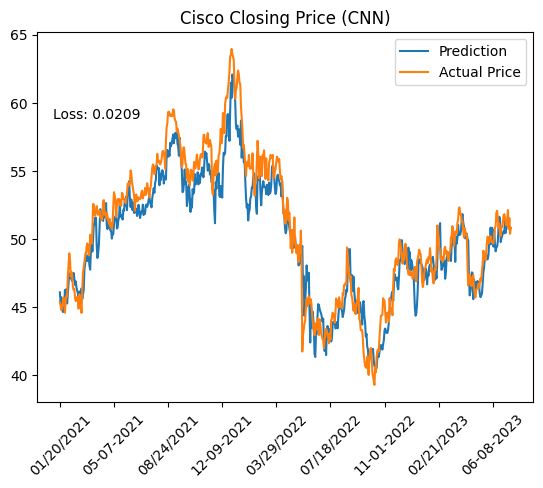

In [103]:

plt.plot(date_data[len(date_data) - len(test_y):], inv_price_prediction, label="Prediction")
plt.plot(inv_actual_price, label="Actual Price")
plt.title("Cisco Closing Price (CNN)")
plt.legend()
plt.figtext(.15, .7, "Loss: 0.0209")
plt.xticks(np.arange(0, len(test_y), 75), rotation=45)
plt.show()
